
############## sentiment CNN performance is as follows: ##############

             precision    recall  f1-score   support

          0       1.00      0.99      0.99       363
          1       0.96      0.99      0.98       137

avg / total       0.99      0.99      0.99       500

total_nb_words:
1467


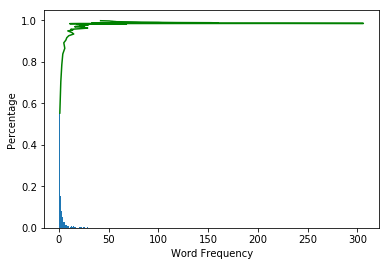

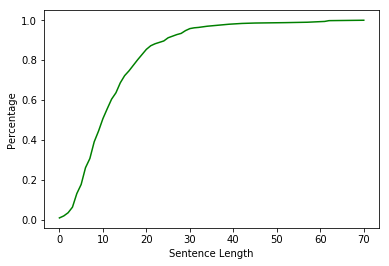

['0' '1']


{'the burger is good': array([ 0.87297601], dtype=float32),
 'the staff is nice': array([ 0.60564882], dtype=float32)}

In [69]:
from string import punctuation
from gensim.models.doc2vec import TaggedDocument
import json
import gensim
import nltk,string
from random import shuffle
from gensim.models import doc2vec
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.regularizers import l2
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk import tokenize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


BEST_MODEL_FILEPATH="best_model"
BEST_SENT_MODEL_FILEPATH="best_sent_model"
MAX_NB_WORDS=1467
MAX_DOC_LEN=200
EMBEDDING_DIM=200
FILTER_SIZES=[2,3,4]
BTACH_SIZE = 64
NUM_EPOCHES = 40

class ReviewAnalyser(object):
    
    # label's cnn model
    label_model = None
    # label's classification: ['amenities' 'environment' 'food' 'location' 'null' 'price' 'service' 'transport']
    label_mlb = None
    # sentiment's cnn model
    sent_model = None
    # sentiment's classification: ['0', '1'] 0: neutral, 1: positive/negative
    sent_mlb = None
    # doc2vector's cnn model
    wv_model = None
    
    
    def __init__(self, data): 
        self.data = data;
        
    @staticmethod    
    def cnn_model(FILTER_SIZES, \
        # filter sizes as a list
        MAX_NB_WORDS, \
        # total number of words
        MAX_DOC_LEN, \
        # max words in a doc
        NUM_OUTPUT_UNITS=1, \
        # number of output units
        EMBEDDING_DIM=200, \
        # word vector dimension
        NUM_FILTERS=64, \
        # number of filters for all size
        DROP_OUT=0.5, \
        # dropout rate
        PRETRAINED_WORD_VECTOR=None,\
        # Whether to use pretrained word vectors
        LAM=0.01,\
        ACTIVATION='sigmoid'):            
        # regularization coefficient
    
        main_input = Input(shape=(MAX_DOC_LEN,), \
                           dtype='int32', name='main_input')

        if PRETRAINED_WORD_VECTOR is not None:
            embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                            output_dim=EMBEDDING_DIM, \
                            input_length=MAX_DOC_LEN, \
                            weights=[PRETRAINED_WORD_VECTOR],\
                            trainable=False,\
                            name='embedding')(main_input)
        else:
            embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                            output_dim=EMBEDDING_DIM, \
                            input_length=MAX_DOC_LEN, \
                            name='embedding')(main_input)

        conv_blocks = []
        for f in FILTER_SIZES:
            conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                          activation='relu', name='conv_'+str(f))(embed_1)
            conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
            conv = Flatten(name='flat_'+str(f))(conv)
            conv_blocks.append(conv)

        z=Concatenate(name='concate')(conv_blocks)
        drop=Dropout(rate=DROP_OUT, name='dropout')(z)

        dense = Dense(192, activation='relu',\
                        kernel_regularizer=l2(LAM),name='dense')(drop)
        preds = Dense(NUM_OUTPUT_UNITS, activation=ACTIVATION, name='output')(dense)
        model = Model(inputs=main_input, outputs=preds)

        model.compile(loss="binary_crossentropy", \
                  optimizer="adam", metrics=["accuracy"]) 

        return model

    # training to change document into vector using gensim
    def pretrain(self):
        with open("test.json", 'r') as f:
            reviews=[]
            for line in f: 
                review = json.loads(line) 
                try:
                    review["text"].strip().lower().encode('ascII')
                except:
                    ;
                else:
                    reviews.append(review["text"])

        sentences=[ [token.strip(string.punctuation).strip() \
                     for token in nltk.word_tokenize(doc.lower()) \
                         if token not in string.punctuation and \
                         len(token.strip(string.punctuation).strip())>=2]\
                     for doc in reviews]


        docs=[TaggedDocument(sentences[i], [str(i)]) for i in range(len(sentences)) ]
        self.wv_model = doc2vec.Doc2Vec(dm=1, min_count=5, window=5, size=200, workers=4)
        self.wv_model.build_vocab(docs) 

        for epoch in range(30):
            # shuffle the documents in each epoch
            shuffle(docs)
            # in each epoch, all samples are used
            self.wv_model.train(docs, total_examples=len(docs), epochs=1)

#         print("Top 5 words similar to word 'price'")
#         print self.wv_model.wv.most_similar('price', topn=5)

#         print("Top 5 words similar to word 'price' but not relevant to 'bathroom'")
#         print self.wv_model.wv.most_similar(positive=['price','money'], negative=['bathroom'], topn=5)

#         print("Similarity between 'price' and 'bathroom':")
#         print self.wv_model.wv.similarity('price','bathroom') 

#         print("Similarity between 'price' and 'charge':")
#         print self.wv_model.wv.similarity('price','charge') 

#         print self.wv_model.wv

    # training labels CNN
    def trainLebels(self, RETRAIN=0, CHECKPERFORM=0):
       
        labels = []
        # fetch labels for each sentence        
        for subdata in self.data[2][0:500]:
            label = []
            for d in subdata.split(","):
                label.append(d.strip())
            labels.append(label)

        mlb = MultiLabelBinarizer()
        Y=mlb.fit_transform(labels)
        self.label_mlb = mlb
#         print mlb.classes_
        np.sum(Y, axis=0)

        tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(self.data[1][0:500])
        NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))
        embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

        for word, i in tokenizer.word_index.items():
            if i >= NUM_WORDS:
                continue
            if word in self.wv_model.wv:
                embedding_matrix[i]=self.wv_model.wv[word]

        voc=tokenizer.word_index
        sequences = tokenizer.texts_to_sequences(self.data[1][0:500])
        padded_sequences = pad_sequences(sequences, \
                                         maxlen=MAX_DOC_LEN, \
                                         padding='post', truncating='post')

        NUM_OUTPUT_UNITS=len(mlb.classes_)

        X_train, X_test, Y_train, Y_test = train_test_split(\
                        padded_sequences, Y, test_size=0.3, random_state=0)

        self.label_model=ReviewAnalyser.cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                        MAX_DOC_LEN, NUM_OUTPUT_UNITS, \
                        PRETRAINED_WORD_VECTOR=embedding_matrix)
        
        if(RETRAIN == 0):
            if os.path.exists("best_model"):
                self.label_model.load_weights("best_model")
                pred=self.label_model.predict(padded_sequences[0:500])
                if CHECKPERFORM == 1:
                    print "\n############## labels CNN performance is as follows: ##############\n"
                    ReviewAnalyser.checkPerform(self.label_model, tokenizer, mlb, sequences, padded_sequences[0:500], Y)
                return

        earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
        checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', \
                                     verbose=2, save_best_only=True, mode='max')

        training=self.label_model.fit(X_train, Y_train, \
                  batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
                  callbacks=[earlyStopping, checkpoint],\
                  validation_data=[X_test, Y_test], verbose=2)
        
        if CHECKPERFORM == 1:
            print "\n############## labels CNN performance is as follows: ##############\n"
            ReviewAnalyser.checkPerform(self.label_model, tokenizer, mlb, sequences, padded_sequences[0:500], Y)
            
    # training sentiment CNN        
    def trainSentiment(self, RETRAIN=0, CHECKPERFORM=0):
        labels = []
        for i,subdata in enumerate(self.data[3][0:500]):
            if subdata == 1:
                labels.append(['1'])
            else:
                labels.append(['0'])

        Y_labels = np.copy(labels)
        mlb = LabelBinarizer()
        Y = mlb.fit_transform(Y_labels)
        self.sent_mlb = mlb
        
        tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(self.data[1][0:500])
        NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))
        embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

        for word, i in tokenizer.word_index.items():
            if i >= NUM_WORDS:
                continue
            if word in self.wv_model.wv:
                embedding_matrix[i]=self.wv_model.wv[word]

        voc=tokenizer.word_index
        sequences = tokenizer.texts_to_sequences(self.data[1][0:500])
        padded_sequences = pad_sequences(sequences, \
                                         maxlen=MAX_DOC_LEN, \
                                         padding='post', truncating='post')

        NUM_OUTPUT_UNITS=len(mlb.classes_)

        X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y, test_size=0.3, random_state=0)

        self.sent_model=ReviewAnalyser.cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                    MAX_DOC_LEN, \
                    PRETRAINED_WORD_VECTOR=embedding_matrix)
        
        if(RETRAIN == 0):
            if os.path.exists("best_sent_model"):
                self.sent_model.load_weights("best_sent_model")
                pred=self.sent_model.predict(padded_sequences[0:500])
                if CHECKPERFORM == 1:
                    print "\n############## sentiment CNN performance is as follows: ##############\n"
                    ReviewAnalyser.checkPerform(self.sent_model, tokenizer, mlb, sequences, padded_sequences[0:500], Y)
                return


        earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
        checkpoint = ModelCheckpoint(BEST_SENT_MODEL_FILEPATH, monitor='val_acc', \
                                     verbose=2, save_best_only=True, mode='max')

        training=self.sent_model.fit(padded_sequences[0:500], self.data[3][0:500], \
                  batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
                  callbacks=[earlyStopping, checkpoint],\
                  validation_data=[padded_sequences[0:500], self.data[3][0:500]], verbose=2) 
        
        if CHECKPERFORM == 1:
            print "\n############## sentiment CNN performance is as follows: ##############\n"
            ReviewAnalyser.checkPerform(self.sent_model, tokenizer, mlb, sequences, padded_sequences[0:500], Y)
        return

    @staticmethod
    def checkPerform(model, tokenizer, mlb, sequences, data_tobe_predicted, Y_actual):
        pred=model.predict(data_tobe_predicted)
        Y_pred=np.copy(pred)
        Y_pred=np.where(Y_pred>0.5,1,0)
        print(classification_report(Y_actual, Y_pred, \
                                    target_names=mlb.classes_))
        total_nb_words=len(tokenizer.word_counts)
        print "total_nb_words:"
        print(total_nb_words)

        word_counts=pd.DataFrame(\
                    tokenizer.word_counts.items(), \
                    columns=['word','count'])
        df=word_counts['count'].value_counts().reset_index()
        df['percent']=df['count']/len(tokenizer.word_counts)
        df['cumsum']=df['percent'].cumsum()

        plt.bar(df["index"].iloc[0:50], df["percent"].iloc[0:50])
        plt.plot(df["index"].iloc[0:50], df['cumsum'].iloc[0:50], c='green')

        plt.xlabel('Word Frequency')
        plt.ylabel('Percentage')
        plt.show()
        
        sen_len=pd.Series([len(item) for item in sequences])

        df=sen_len.value_counts().reset_index().sort_values(by='index')
        df.columns=['index','counts']

        df=df.sort_values(by='index')
        df['percent']=df['counts']/len(sen_len)
        df['cumsum']=df['percent'].cumsum()
        
        plt.plot(df["index"], df['cumsum'], c='green')

        plt.xlabel('Sentence Length')
        plt.ylabel('Percentage')
        plt.show()
        
    # predict labels for text, need to execute trainLabels first
    def predictLabels(self, text_arr=[]):
        if len(text_arr)==0:
            return
        rtn = {}
        tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(self.data[1][0:500])
        sub_sequences = tokenizer.texts_to_sequences(text_arr)
        padded_sub_sequences = pad_sequences(sub_sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', truncating='post')
        sub_pred = self.label_model.predict(padded_sub_sequences)
        for i, key in enumerate(text_arr):
            rtn[key] = sub_pred[i]
        print self.label_mlb.classes_
        return rtn
        
    def predictSentiment(self, text_arr=[]):
        if len(text_arr)==0:
            return
        rtn = {}
        tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(self.data[1][0:500])
        sub_sequences = tokenizer.texts_to_sequences(text_arr)
        padded_sub_sequences = pad_sequences(sub_sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', truncating='post')
        sub_pred = self.sent_model.predict(padded_sub_sequences)
        for i, key in enumerate(text_arr):
            rtn[key] = sub_pred[i]
        print self.sent_mlb.classes_
        return rtn
        
data=pd.read_csv("data_sample.csv",header=None)
ra = ReviewAnalyser(data)
ra.pretrain()
#ra.trainLebels(RETRAIN=0,CHECKPERFORM=0)
ra.trainSentiment(RETRAIN=0,CHECKPERFORM=0)
#ra.predictLabels(text_arr=["the burger is good", "the staff is nice"])
#ra.predictSentiment(text_arr=["the burger is good", "the staff is nice"])
